In [1]:
from htm.bindings.sdr import SDR, Metrics
from htm.encoders.date import DateEncoder
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from datetime import datetime
import hashlib
import os
from htm.encoders.rdse import RDSE, RDSE_Parameters
import time
import traceback
import hashlib
import matplotlib.pyplot as plt

In [2]:
class ReflexiveMemory:
  def __init__(self, reflexSize):
    self.acKey0 = None
    self.pairs = {}
    self.anomalyRM = []
    self.anomalyTM = []
    self.enableLearn = False
    self.tableSize  = reflexSize
    self.historyRM = []
    self.historyTM = []
    self.historyGT = []

  def add(self, denseColumns):
    acKey1 = '-'.join(map(str, denseColumns.sparse))
    if(self.acKey0 != None):

      sequence = self.pairs.get(self.acKey0, {})
      sequence_data = sequence.get(acKey1, {
         "count": 0,
         "time": datetime.now()
      })
      sequence_data["count"] = sequence_data["count"] + 1
      sequence_data["time"] = datetime.now()

      if self.pairs.get(self.acKey0, None) is None:
        self.pairs[self.acKey0] = { acKey1: sequence_data }
      else:
        self.pairs[self.acKey0][acKey1] = sequence_data

      table_entries = 0
      oldKey1 = None
      oldKey2 = None
      oldTime = datetime.now()
      for key1, value1 in self.pairs.items():
        table_entries = table_entries + len(value1.items())
        for key2, value2 in value1.items():
          if value2['time'] < oldTime:
            oldKey1 = key1
            oldKey2 = key2
            oldTime = datetime.now()
      if table_entries > self.tableSize:
        self.enableLearn = True
        del self.pairs[oldKey1][oldKey2]
        if len(self.pairs[oldKey1].items()) == 0:
          del self.pairs[oldKey1]

    self.acKey0 = acKey1

  def predict(self, denseColumns):
    return_count = 0
    return_sdr = None

    acKey = '-'.join(map(str, denseColumns.sparse))
    sequences = self.pairs.get(acKey, {})
    for sequence_key, sequence_data in sequences.items():
      if sequence_data["count"] > return_count:
        return_count = sequence_data["count"]
        return_sdr = sequence_key

    if return_sdr is not None:
      tmp_sdr = SDR( denseColumns.dimensions )
      tmp_sdr.sparse = list(map(int, return_sdr.split('-')))
      return_sdr = tmp_sdr
    else:
      return_count = None

    return return_count, return_sdr

  def learn(self, denseColumns1, sp, tm):

    tm.activateDendrites(True)
    predictiveColumns = SDR( tm.getPredictiveCells().dimensions[0] )
    predictiveColumns.sparse = list(set(sorted(list(np.where(tm.getPredictiveCells().dense == 1)[0]))))

    activeColumns1 = SDR( predictiveColumns.dimensions )
    sp.compute(denseColumns1, False, activeColumns1)

    denseColumns0 = SDR( denseColumns1.dimensions )
    denseColumns0.sparse = list(map(int, self.acKey0.split('-')))
    activeColumns0 = SDR( predictiveColumns.dimensions )
    sp.compute(denseColumns0, False, activeColumns0)
 
    reflexiveCount, denseReflexiveColumns = self.predict(denseColumns0)
    reflexiveColumns = SDR( predictiveColumns.dimensions )
    if denseReflexiveColumns is not None:
      sp.compute(denseReflexiveColumns, False, reflexiveColumns)    

    overlapRM = 1 - np.count_nonzero((reflexiveColumns.dense & activeColumns1.dense)) / np.count_nonzero(activeColumns1.dense)
    self.anomalyRM.append( overlapRM )

    overlapTM = 1 - np.count_nonzero((predictiveColumns.dense & activeColumns1.dense)) / np.count_nonzero(activeColumns1.dense)
    self.anomalyTM.append( overlapTM )

    self.historyRM.append( reflexiveColumns.dense )
    self.historyTM.append( predictiveColumns.dense )
    self.historyGT.append( activeColumns1.dense )

  def compute(self, denseColumns, sp, tm):
    if self.acKey0 is not None:
      self.learn(denseColumns, sp, tm)  
    self.add(denseColumns)
  

In [3]:
inputSources = [
   "monthly_sp500.csv",
   "weekly_dow_jones.csv",
   "weekly_nasdaq.csv",
   "weekly_sp500.csv",
   "monthly_vix_close.csv",
   "monthly_vix_high.csv",
   "monthly_vix_low.csv",
   "monthly_vix_open.csv",
   "daily_natural_gas.csv",
   "daily_oil_prices.csv",
   "value1_vix_close.csv",
   "value1_vix_high.csv",
   "value1_vix_low.csv",
   "value1_vix_open.csv"
]

In [4]:

config = {
    'enc': {
        "value" :
            {'resolution': 0.88, 'size': 700, 'sparsity': 0.02},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (1638,),
        'potentialPct': 0.85,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.006,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'boostStrength': 3.0,
        'wrapAround': True,
        'seed': 1,
        'learn': False,
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000},
    'learnRows': 100,
    'reflexSize': 128
}


In [5]:
input_path = pathlib.Path('../datasets/numenta')

for dataset in inputSources:

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
        
    scalarEncoderParams = RDSE_Parameters()
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoderParams.sparsity = config["enc"]["value"]["sparsity"]
    scalarEncoderParams.resolution = config["enc"]["value"]["resolution"]
    scalarEncoder = RDSE( scalarEncoderParams )
    encodingWidth = (scalarEncoder.size)

    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory( config['reflexSize'] )

    enc_info = Metrics( [encodingWidth], 999999999)
    sp_info = Metrics( sp.getColumnDimensions(), 999999999 )
    tm_info = Metrics( [tm.numberOfCells()], 999999999 )
    anomaly_history = AnomalyLikelihood(config["anomaly"]["period"])

    inputs = []
    anomaly = []
    anomalyProb = []
   
    print("\n"+dataset)
    try:
        
        for count, record in enumerate(records):

            consumption = float(record[1])

            inputs.append( consumption )
            consumptionBits = scalarEncoder.encode(consumption)

            encoding = SDR( consumptionBits )
            enc_info.addData( encoding )
            
            activeColumns = SDR( sp.getColumnDimensions() )

            learn_sp = config['sp']['learn']
            learn_tm = config['tm']['learn']
            if count < config['learnRows']:
                learn_sp = True
                learn_tm = True

            rm.compute(encoding, sp, tm)

            sp.compute(encoding, learn_sp, activeColumns)
            sp_info.addData( activeColumns )

            tm.compute(activeColumns, learn=learn_tm)
            tm_info.addData( tm.getActiveCells().flatten() )

            anomaly.append( tm.anomaly )
            anomalyProb.append( anomaly_history.compute(tm.anomaly) )

    except Exception as e:
        print(traceback.format_exc())
        print(e)

    break



monthly_sp500.csv


In [6]:
# Calculate averages
average_rm_anomaly = sum(rm.anomalyRM) / len(rm.anomalyRM)
average_tm_anomaly = sum(rm.anomalyTM) / len(rm.anomalyTM)

# Print the results
print("The anomaly scores are:", average_rm_anomaly, "and", average_tm_anomaly)
print("Anomaly score samples:", len(rm.anomalyRM), "and", len(rm.anomalyTM))


The anomaly scores are: 0.5054296506137865 and 0.2737016052880074
Anomaly score samples: 1765 and 1765


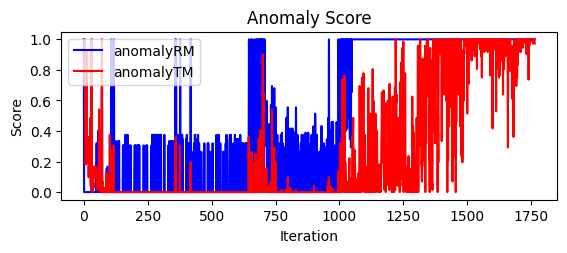

In [7]:
plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.plot(np.arange(len(rm.anomalyRM)), rm.anomalyRM, 'blue',
    np.arange(len(rm.anomalyTM)), rm.anomalyTM, 'red',)
plt.legend(labels=('anomalyRM', 'anomalyTM'))
plt.show()


In [8]:
for key1, value1 in rm.pairs.items():
    for key2, value2 in value1.items():
        result = hashlib.md5(key1.encode())
        print(result.hexdigest(), end=' ')
        result = hashlib.md5(key2.encode())
        print(result.hexdigest(), end=' ')
        print(value2["count"], end=' ')
        print(value2["time"].timestamp())


e1e41dfa2e1cf9744b6f74e89599f34b e1e41dfa2e1cf9744b6f74e89599f34b 120 1733953689.724059
e1e41dfa2e1cf9744b6f74e89599f34b 2cb35831cee146b093adc51c2c772e40 12 1733953689.590196
e1e41dfa2e1cf9744b6f74e89599f34b dbe4591a439532eda7571a54fe7bfac9 13 1733953689.595717
e1e41dfa2e1cf9744b6f74e89599f34b 8b127011f2efc000bc78a8c67da1f061 1 1733953689.724408
2cb35831cee146b093adc51c2c772e40 2cb35831cee146b093adc51c2c772e40 52 1733953689.592474
2cb35831cee146b093adc51c2c772e40 e1e41dfa2e1cf9744b6f74e89599f34b 12 1733953689.592676
2cb35831cee146b093adc51c2c772e40 e5cea82b9ce167022b60c15623fd460e 2 1733953689.544659
e5cea82b9ce167022b60c15623fd460e e5cea82b9ce167022b60c15623fd460e 20 1733953689.545789
e5cea82b9ce167022b60c15623fd460e 2cb35831cee146b093adc51c2c772e40 2 1733953689.546322
dbe4591a439532eda7571a54fe7bfac9 e1e41dfa2e1cf9744b6f74e89599f34b 13 1733953689.723736
dbe4591a439532eda7571a54fe7bfac9 dbe4591a439532eda7571a54fe7bfac9 81 1733953689.60044
dbe4591a439532eda7571a54fe7bfac9 4bcba02b79f0b

In [9]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import seaborn as sns

def anomalyScore(x, y):
    if np.count_nonzero(y) != 0:
        return 1 - np.count_nonzero((x & y)) / np.count_nonzero(y)
    return 1

def match(y, x, idx1):
  score1 = anomalyScore(y[idx1], x[idx1])
  if score1 > 0.9:
     idx_closest = None
     score_closest = None
     for idx2 in range(n_samples):
        score2 = anomalyScore(y[idx2], x[idx1])
        if score_closest is None or score_closest > score2:
            score_closest = score2
            idx_closest = idx2
     return idx_closest
  return idx1

n_samples = len(rm.historyGT)
Y_labels = list(range(n_samples))

X_labels = [ match(rm.historyGT, rm.historyRM, idx) for idx in range(n_samples)]
accuracy = accuracy_score(Y_labels, X_labels)
precision, recall, fscore, support = precision_recall_fscore_support(Y_labels, X_labels, average='macro')

print('\nReflex Memory:')
print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F-Score",fscore)
print("Support",support)

X_labels = [ match(rm.historyGT, rm.historyTM, idx) for idx in range(n_samples)]
accuracy = accuracy_score(Y_labels, X_labels)
precision, recall, fscore, support = precision_recall_fscore_support(Y_labels, X_labels, average='macro')

print('\nSequence Memory:')
print("Accuracy",accuracy)
print("Precision",precision)
print("Recall",recall)
print("F-Score",fscore)
print("Support",support)

# cf_matrix = confusion_matrix(Y_labels, X_labels)
# sns.heatmap(cf_matrix, annot=True)

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Reflex Memory:
Accuracy 0.5592067988668555
Precision 0.5586409539360042
Recall 0.5592067988668555
F-Score 0.5586416793782233
Support None

Sequence Memory:
Accuracy 0.8277620396600567
Precision 0.8186999136507552
Recall 0.8277620396600567
F-Score 0.8215357724067266
Support None


/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
